In [1]:
import csv
from datetime import date
import json
import statistics
from collections import Counter

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

from tqdm.notebook import tqdm

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import spacy
nlp = spacy.load('nl_core_news_sm')

import statsmodels.api as sm

#### load datasets

In [2]:
questions = json.load(open('data/questions.json', 'r', encoding='utf8'))
# get the fieldnames from the first output
reader = csv.DictReader(open('data/tscan/0_azure.txt.document.csv', 'r'))
df_main = pd.read_csv('data/dataset_classification.csv', index_col=0)

#### Combine datasets
1. Combine to one big dataset
2. distil to one smaller dataset with only Google

In [3]:
columns = ['question_id', 'provider', 'sentence_en', 'sentence_nl', 'score'] + reader.fieldnames #+ maxi + mini
data = []

scores = ['best', 'middle', 'worst']

for index, dfrow in tqdm(df_main.iterrows(), total=len(df_main)):
    question = questions['questions'][dfrow['question_id']]

    for answer in question['answers']:
        row = {}
        row['provider'] = answer['answer'][11:]
        ranking = dfrow['ranking'].split(',')

        row['score'] = scores[ranking.index( row['provider'])]
        row['sentence_en'] = question['question']
        row['sentence_nl'] = answer['text']
        row['question_id'] = dfrow['question_id']

        reader = csv.DictReader(open(f"data/tscan/{str(dfrow['question_id'])}_{row['provider']}.txt.document.csv", 'r'))
        for csvrow in reader:
            for fieldname in reader.fieldnames:
                try:
                    row[fieldname] = float(csvrow[fieldname])
                except:
                    row[fieldname] = float(0)

        data.append(row)
df = pd.DataFrame(data, columns = columns)

df.sort_values(by=['question_id', 'provider'], inplace=True)
df.reset_index(inplace=True)

ybinair = {'best':1, 'middle':0, 'worst':0}
df['yvalue'] = df['score'].apply(lambda x: ybinair[x])
del df['index']
df.head(6)

  0%|          | 0/213 [00:00<?, ?it/s]

,question_id,provider,sentence_en,sentence_nl,score,Inputfile,Par_per_doc,Zin_per_doc,Word_per_doc,Alpino_status,...,Log_prob_bwd,Log_prob_bwd_inhwrd,Log_prob_bwd_zn,Log_prob_bwd_inhwrd_zn,Entropie_bwd,Entropie_bwd_norm,Perplexiteit_bwd,Perplexiteit_bwd_norm,Eigen_classificatie,yvalue
0,0,azure,It authorized the Secretary of the Interior to...,Het machtigde de Minister van het Binnenland o...,worst,0.0,1.0,1.0,49.0,0.0,...,-2.82975,-4.03899,-2.79206,-4.27869,4.63601,0.090902,24.86440,0.009560,0.0,0
1,0,google,It authorized the Secretary of the Interior to...,Het gaf de minister van Binnenlandse Zaken toe...,best,0.0,1.0,1.0,47.0,0.0,...,-2.48653,-3.66776,-2.49209,-3.73416,6.91454,0.144053,120.63800,0.052360,0.0,1
2,0,ibm,It authorized the Secretary of the Interior to...,De minister heeft de minister van Binnenlandse...,middle,0.0,1.0,1.0,58.0,0.0,...,-3.73402,0.00000,0.00000,0.00000,11.31350,0.188558,2545.07000,0.706964,0.0,0
3,1,azure,It connects to a television via a combined A/V...,Het maakt verbinding met een televisie via een...,worst,0.0,1.0,1.0,15.0,0.0,...,-8.29240,0.00000,0.00000,0.00000,1.54676,0.073655,2.92160,0.006625,0.0,0
4,1,google,It connects to a television via a combined A/V...,Het wordt aangesloten op een televisie via een...,best,0.0,1.0,1.0,14.0,0.0,...,-8.23087,0.00000,0.00000,0.00000,1.59306,0.079653,3.01689,0.007542,0.0,1
5,1,ibm,It connects to a television via a combined A/V...,Het verbindt met een televisie via een gecombi...,middle,0.0,1.0,1.0,13.0,0.0,...,-9.06666,0.00000,0.00000,0.00000,1.68420,0.099071,3.21363,0.011120,0.0,0


In [4]:
# Only focus on Google

df_google = df.loc[df.provider=='google'].copy()
df_google['bestrest'] = df_google['score'].apply(lambda x: 1 if x =="best" else 0)

delete_cols = ['question_id', 'provider', 'sentence_en', 'sentence_nl', 'score', 'Inputfile', 'Eigen_classificatie', 'yvalue', 'bestrest']
cols = [col for col in df_google.columns if col not in delete_cols]

X = df_google.loc[:, df_google.columns.isin(cols)].copy()
X.fillna(0, inplace=True)

y = df_google.loc[:, df_google.columns == 'bestrest']

print("Row count", len(X))

Row count 213


#### Smote balancing

In [5]:
print("Column count", len(columns))

os = SMOTE(random_state=2)
y_arr = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_arr, test_size=0.3, random_state=0)
columns = X_train.columns


os_data_X,os_data_y=os.fit_resample(X, y_arr)#X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# Train en test set
os_data_X_train,os_data_y_train=os.fit_resample(X_train, y_train)
os_data_X_train = pd.DataFrame(data=os_data_X_train,columns=columns )
os_data_y_train= pd.DataFrame(data=os_data_y_train,columns=['y'])

os_data_X_test,os_data_y_test=os.fit_resample(X_test, y_test)
os_data_X_test = pd.DataFrame(data=os_data_X_test,columns=columns )
os_data_y_test= pd.DataFrame(data=os_data_y_test,columns=['y'])



print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))
print("Aantal columns", len(columns))

Column count 464
length of oversampled data is  270
Number of no subscription in oversampled data 135
Number of subscription 135
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5
Aantal columns 457


#### Finding features
1. With RFE
2. With Extra Tree Classifier

In [6]:
# RFE
rfe = RFE(DecisionTreeClassifier(), n_features_to_select=20)
rfe = rfe.fit(X, y_arr)#, os_data_y)
[c for x,c in enumerate(X.columns) if rfe.support_[x]]

['Freq1000_inhwrd',
 'Freq3000_inhwrd_zonder_abw',
 'Let_per_wrd_nw',
 'Wrd_freq_log_zn_corr',
 'Freq1000_corr',
 'Wrd_per_dz',
 'Wrd_per_nwg',
 'Nom_d',
 'Ontk_tot_d',
 'AL_vg_conj',
 'AL_ww_bnwbwp',
 'Bijw_bep_dz',
 'Ov_bijv_bep_d',
 'Props_dz_tot',
 'Inhwrd_d_zonder_abw',
 'Conn_TTR',
 'Causaal_d',
 'Conc_nw_ruim_p',
 'Plaats_nw_d',
 'Vg_d']

In [7]:
extra_tree_class_model = ExtraTreesClassifier()
extra_tree_class_model.fit(X,y)
feat_importances = pd.Series(extra_tree_class_model.feature_importances_, index=X.columns)
feat_importances.nlargest(20)

C:\Users\chaim\AppData\Local\Temp\ipykernel_49408\993186844.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_tree_class_model.fit(X,y)


Vragen_p                0.011401
Dzin_per_wrd            0.010126
Zin_per_wrd             0.009508
Ontk_zin_d              0.009375
Vragen_d                0.008833
Pv_ww1_per_zin          0.008813
Ontk_tot_d              0.008558
Pv_Frog_d               0.008184
Ww_d                    0.008085
Lijdv_dz                0.007999
Lijdv_d                 0.007968
Word_per_doc            0.007374
Wrd_per_nwg             0.007321
Ww_tt_p                 0.007207
Vnw_d                   0.006791
Let_per_wrd_nsam        0.006467
Vd_vrij_d               0.006209
Ontk_tot_dz             0.006189
Inhwrd_dz_zonder_abw    0.006165
Freq20000_nsam_nw       0.006054
dtype: float64

#### Logistic regression

In [8]:
manually_added_cols = [
    'Lem_freq_zn_log_zonder_abw',
    'Hzin_conj',
    'Perplexiteit_bwd',
]
extra_trees_cols = [
    'Pv_ww1_per_zin',
    'Ontk_tot_d',
]
rfe_cols = [
    'Freq1000_inhwrd',
    'Conn_TTR',   
    'Ww_d',
]

ordered_cols = [
    rfe_cols[0],
    manually_added_cols[0],
    manually_added_cols[1],
    extra_trees_cols[0],
    extra_trees_cols[1],
    rfe_cols[1],
    rfe_cols[2],
    manually_added_cols[2],
]

X1=os_data_X[ ordered_cols ]
y1=os_data_y['y']

logit_model=sm.Logit(list(y1),X1.astype(float))

result=logit_model.fit()
response = result.predict(X1)

print(result.summary())
# print(result.summary().as_latex())

Optimization terminated successfully.
         Current function value: 0.548231
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  270
Model:                          Logit   Df Residuals:                      262
Method:                           MLE   Df Model:                            7
Date:                Wed, 05 Oct 2022   Pseudo R-squ.:                  0.2091
Time:                        06:00:51   Log-Likelihood:                -148.02
converged:                       True   LL-Null:                       -187.15
Covariance Type:            nonrobust   LLR p-value:                 3.124e-14
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Freq1000_inhwrd                2.0691      1.026      2.016      0.044      

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


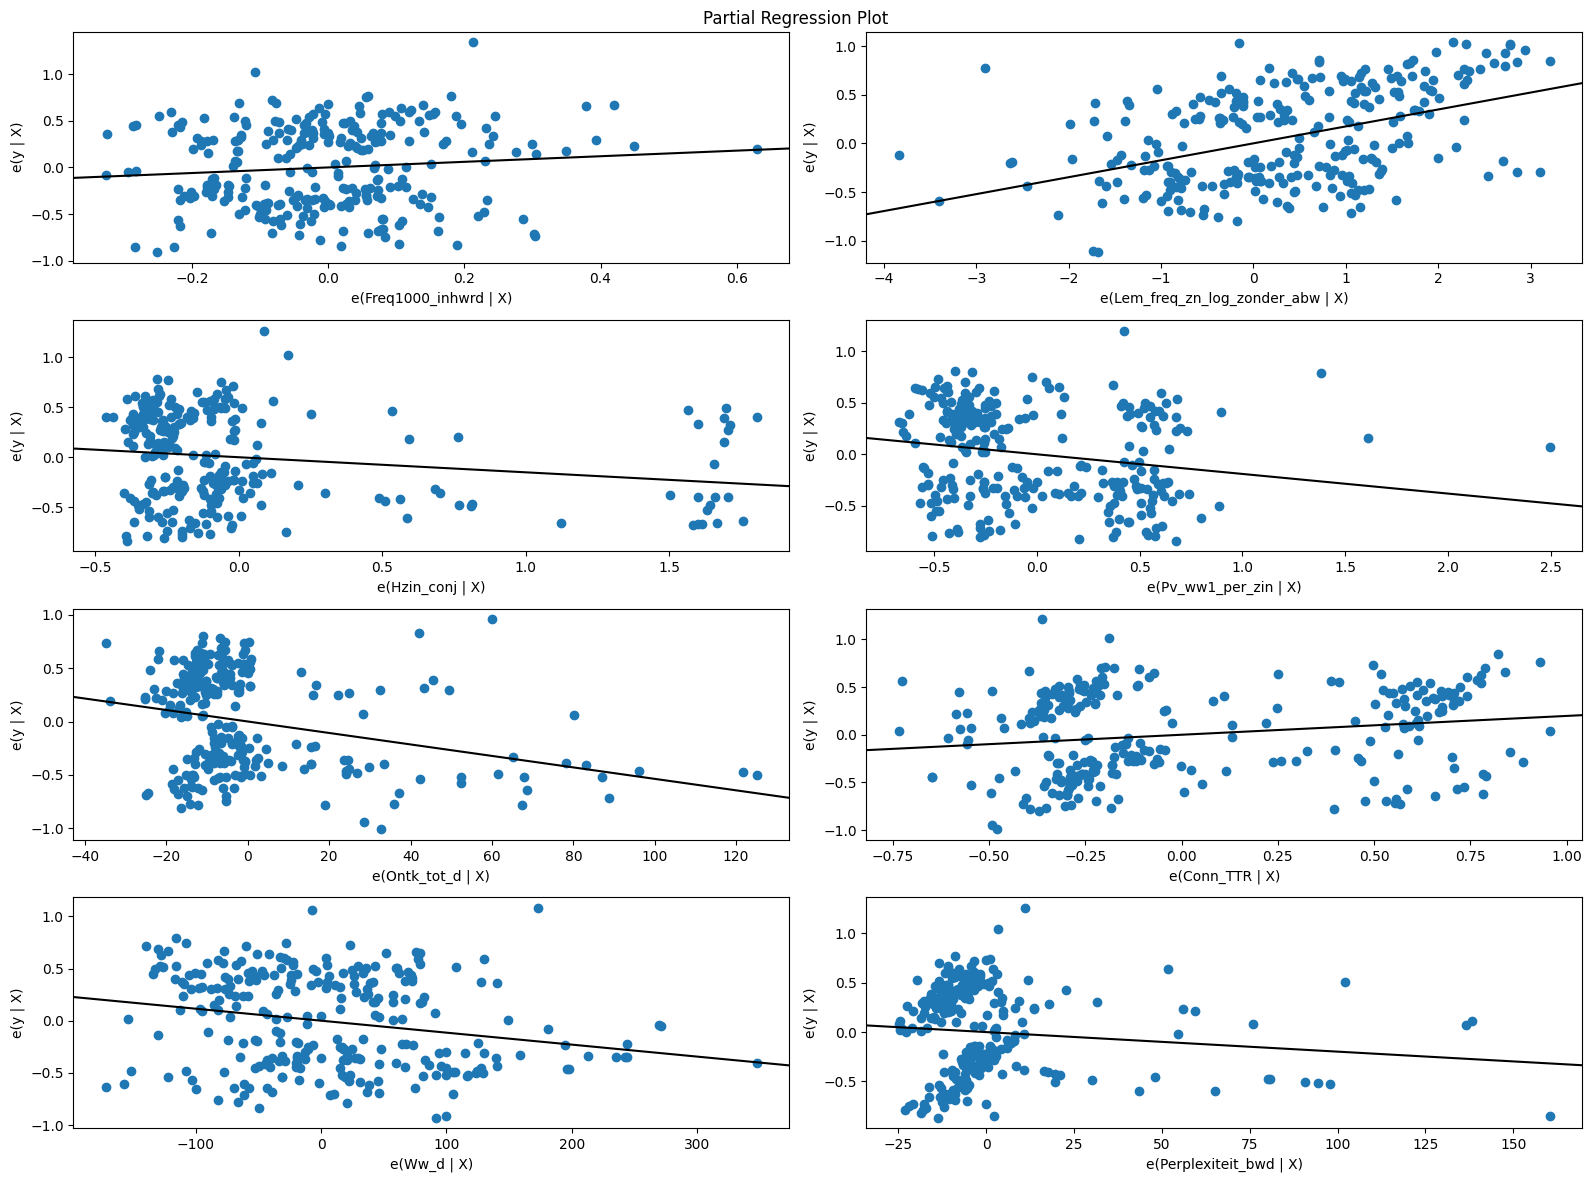

In [9]:
fig = plt.figure(figsize=(16, 12))
regression = sm.graphics.plot_partregress_grid(result, fig=fig)
regression.tight_layout(pad=1.0)
# plot_partregress_grid(results, fig=fig)
plt.show()

#### Predicting

In [10]:
logreg = LogisticRegression( max_iter = 1000)
logreg.fit(os_data_X_train[ordered_cols], os_data_y_train['y'].to_list())

y_pred = logreg.predict(os_data_X_test[ordered_cols])

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(os_data_X_test[ordered_cols], os_data_y_test)))
print(classification_report(os_data_y_test, y_pred, labels=[0,1]))

Accuracy of logistic regression classifier on test set: 0.59
              precision    recall  f1-score   support

           0       0.62      0.45      0.52        40
           1       0.57      0.72      0.64        40

    accuracy                           0.59        80
   macro avg       0.59      0.59      0.58        80
weighted avg       0.59      0.59      0.58        80



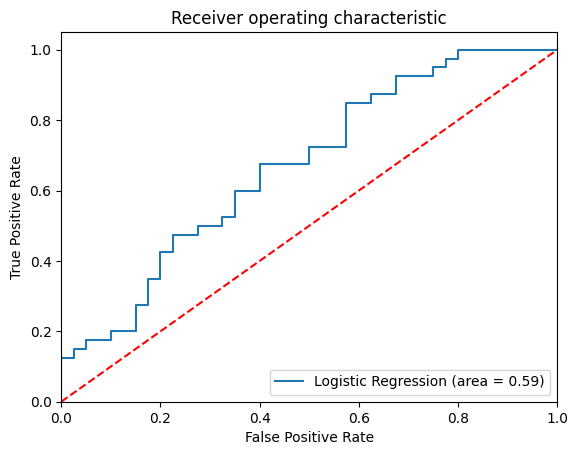

In [11]:
logit_roc_auc = roc_auc_score(os_data_y_test['y'], logreg.predict(os_data_X_test[ordered_cols]))
fpr, tpr, thresholds = roc_curve(os_data_y_test['y'], logreg.predict_proba(os_data_X_test[ordered_cols])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Futher look at the features

In [12]:
for col in ordered_cols:
    print(f"{col} (Google not best) mean:", statistics.mean(df_google[df_google['yvalue']==0][col].to_list()))
    print(f"{col} mean:", statistics.mean(df_google[col].to_list()))
    print(f"{col} (Google best) mean:", statistics.mean(df_google[df_google['yvalue']==1][col].to_list()))
    print()

Freq1000_inhwrd (Google not best) mean: 0.22817989358974358
Freq1000_inhwrd mean: 0.2631174023474178
Freq1000_inhwrd (Google best) mean: 0.28330351851851854

Lem_freq_zn_log_zonder_abw (Google not best) mean: 4.0790902564102565
Lem_freq_zn_log_zonder_abw mean: 4.20958882629108
Lem_freq_zn_log_zonder_abw (Google best) mean: 4.284988

Hzin_conj (Google not best) mean: 0.19230769230769232
Hzin_conj mean: 0.1643192488262911
Hzin_conj (Google best) mean: 0.14814814814814814

Pv_ww1_per_zin (Google not best) mean: 0.47435897435897434
Pv_ww1_per_zin mean: 0.3427230046948357
Pv_ww1_per_zin (Google best) mean: 0.26666666666666666

Ontk_tot_d (Google not best) mean: 16.73613717948718
Ontk_tot_d mean: 9.360561502347418
Ontk_tot_d (Google best) mean: 5.099117777777778

Conn_TTR (Google not best) mean: 0.266025641025641
Conn_TTR mean: 0.3658059483568075
Conn_TTR (Google best) mean: 0.4234567925925926

Ww_d (Google not best) mean: 199.4584371794872
Ww_d mean: 166.83994835680753
Ww_d (Google best) me

In [13]:
df_temp = df[df['sentence_en'] == "Under the regulations of the California Constitution, no runoff election was required."]
df_temp = df_temp[['provider','score']+ordered_cols]
df_temp

,provider,score,Freq1000_inhwrd,Lem_freq_zn_log_zonder_abw,Hzin_conj,Pv_ww1_per_zin,Ontk_tot_d,Conn_TTR,Ww_d,Perplexiteit_bwd
342,azure,middle,0.000000,4.14163,0.0,0.0,76.9231,0.0,153.8460,3.97500
343,google,worst,0.000000,3.48411,0.0,0.0,83.3333,0.0,166.6670,4.91527
344,ibm,best,0.166667,4.32264,0.0,0.0,71.4286,0.0,71.4286,6.23429


In [14]:
df_temp = df[df['sentence_en'] == "There is also the related British Empire Medal, whose recipients are affiliated with, but not members of, the order."]
df_temp = df_temp[['provider','score']+ordered_cols]
df_temp

,provider,score,Freq1000_inhwrd,Lem_freq_zn_log_zonder_abw,Hzin_conj,Pv_ww1_per_zin,Ontk_tot_d,Conn_TTR,Ww_d,Perplexiteit_bwd
279,azure,best,0.500000,4.63039,1.0,0.0,50.0000,1.0,150.00,14.53150
280,google,worst,0.454545,4.43386,1.0,0.0,43.4783,1.0,260.87,28.42390
281,ibm,middle,0.625000,4.44133,0.0,0.0,50.0000,1.0,200.00,9.79599


In [15]:
df_temp = df[df['sentence_en'] == "How was the Portuguese bailout implemented?"]
df_temp = df_temp[['provider','score','sentence_nl']+ordered_cols]
df_temp

,provider,score,sentence_nl,Freq1000_inhwrd,Lem_freq_zn_log_zonder_abw,Hzin_conj,Pv_ww1_per_zin,Ontk_tot_d,Conn_TTR,Ww_d,Perplexiteit_bwd
636,azure,middle,Hoe werd de Portugese reddingsoperatie uitgevo...,0.25,3.47772,0.0,1.0,0.0,0.0,333.333,1.58957
637,google,worst,Hoe is de Portugese reddingsoperatie geïmpleme...,0.25,2.94337,0.0,1.0,0.0,0.0,333.333,1.69840
638,ibm,best,Hoe is de Portugese bailout uitgevoerd?,0.25,3.03901,0.0,1.0,0.0,0.0,333.333,1.70063


In [16]:
print(Counter(df['Hzin_conj'].to_list()).most_common())
print(Counter(df['Pv_ww1_per_zin'].to_list()).most_common())

[(0.0, 597), (2.0, 33), (1.0, 9)]
[(0.0, 437), (1.0, 197), (2.0, 4), (3.0, 1)]


In [17]:
# Word Count comparison
question_ids_google_worst = df[(df['score'] == 'worst')&(df['provider'] == 'google')]['question_id'].to_list()
wordcount = {'higher':0, 'same':0, 'lower':0 }
for question_id in question_ids_google_worst:
    best_sent =  len(nlp(df[(df['question_id'] == question_id)&(df['score'] == 'best')]['sentence_nl'].to_list()[0]))
    worst_sent = len(nlp(df[(df['question_id'] == question_id)&(df['score'] == 'worst')]['sentence_nl'].to_list()[0]))
    if worst_sent > best_sent:
        wordcount['higher'] += 1
    elif worst_sent < best_sent:
        wordcount['lower'] += 1
    elif worst_sent == best_sent:
        wordcount['same'] += 1
    #for index, row in df[df['question_id'] == qid]:
print(wordcount)

{'higher': 12, 'same': 6, 'lower': 7}
